In [9]:
#!pip3 install seaborn
#!pip3 install plotly
#!pip3 install sklearn
#!pip3 install xgboost

# Prediction Algorithms

The main idea is to predict the next day low, upper, open and close to determine a strategy for the next day

In [10]:
import pandas as pd
from datetime import datetime
from datetime import date 
import numpy as np

from time import sleep
from tqdm.notebook import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split as tts
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR

# Functions

In [11]:
#Conversion from strings to numeric
def strnum(x):
    try:
        x=x.replace(',','')
        return float(x)
    except:
        return x

#-----------movingAvg function-----------------
#Calculates the Moving Average

#df - list with the dataframes
#x - index of the coin, e.g. 0- BTC, 1-ETH... of the databases' list who contains the collections of data
#dname - name of the destination column of the moving average calculation (not creared yet)
#oname - name of the origin column of the data to take the information for the moving avarege
#msize - number of registers to calculate the moving average

def movingAvg(df,x,dname,oname,msize):
    df[x][dname] = 0.0
    for i in range(len(df[x])):
        temp=0.0
        if i<msize:
            pass
        else:
            for j in range(msize):
                temp+= df[x][oname][i-msize+j]
            df[x][dname][i]=temp/msize
            
            
#-----------------oheDate--------------------
#Makes one hot econfing to date depending day of the week, day of the month, week of year and month of year

def oheDate(df,x):
    df[x]['weekday']=df[x]['date']
    df[x]['weekday']=df[x]['weekday'].apply(lambda z: str(z.weekday()))
    
    #df[x]['calendarweek']=df[x]['date']
    #df[x]['calendarweek']=df[x]['date'].apply(lambda z: str(z.isocalendar()[1]))
    
    #df[x]['dayofmonth']=df[x]['date']
    #df[x]['dayofmonth']=df[x]['date'].apply(lambda z: str(z.day))
    
    #df[x]['month']=df[x]['date']
    #df[x]['month']=df[x]['date'].apply(lambda z: str(z.month))
    
    #Contanating dummies
    ohe=pd.get_dummies(df[x][['weekday']])#,'calendarweek']])#,'dayofmonth','month']])
    df[x]=pd.concat([df[x],ohe],axis=1)
    #Eliminating categorical columns
    df[x].drop(columns=['weekday'], inplace=True)
    
    
#--------------------yesterday-----------------
#Takes n "days" to the current day as new column (parameter) for the prediction
def yesterday(df,x,days=1,closev=True,openv=True,highv=True,lowv=True,volumev=True):
    
    #Values selector from the function inputs
    values_names=['close','open','high','low','volume']
    values=[closev,openv,highv,lowv,volumev]
    vals=[]
    
    for i,e in enumerate(values):
        if e==True:
            vals.append(values_names[i])
    
    yestvals=[]#List of added variables
    
    #Main set    
    for day in range(days):
        for val in vals:
            y=val+'_'+str(day)
            df[x]['yesterday_'+y]=0.0
            yestvals.append('yesterday_'+y)
            for i in range(len(df[x])-1):
                df[x]['yesterday_'+y][i+1]=df[x][val][i]
    
    return yestvals

# Predictior Function

In [14]:
def predictor(data=data,end=0):
    #Create Dataframe for predictions
    preds= pd.DataFrame(columns=metricas)
    preds['coin'] =""
    cols=preds.columns.tolist()
    cols=cols[-1:]+cols[:-1]
    preds=preds[cols]
    preds

    for x in tqdm(range(len(coins))):
        test=data[x][35:len(data[x])-1-end] #35 is 26 + 9 for all the number of samples who doesn't has Moving Avg  
        dc=['date','open','close','low','high','volume']
        timevars = [ 'weekday_'+ str(x) for x in range(7)]

        #Adding new row for predictions
        preds=preds.append([0], ignore_index=True).drop(0,axis=1)
        preds=preds[cols]
        preds['coin'][x]=coins[x]

        for m in metricas:
            #Predictions
            X_train, X_test, y_train, y_test=tts(test[['PMEF'+m,'PMES'+m,'MACD'+m,'MACD9'+m]+timevars+yv],test[m], shuffle=True,random_state=100,test_size=.1)
            modelo=XGBR()
            modelo.fit(X_train, y_train)
            preds[m][x]=modelo.predict(data[x][len(data[x])-1-end:len(data[x])-end][['PMEF'+m,'PMES'+m,'MACD'+m,'MACD9'+m]+timevars+yv])[0]
            #train_score=modelo.score(X_train, y_train)
            #test_score=modelo.score(X_test, y_test)
            #print ('Score para', coins[x],m,train_score, test_score)

    #Getting oppenings to make initial corrections

    preds['ropen']=0.0
    for i,e in enumerate(coins):
        preds.ropen[i]=data[i]['open'][len(data[i])-1-end]

    preds['corr']=preds.ropen - preds.open
    preds['pcorr']= (1 - preds.open/preds.ropen)*100
    preds['pcorr']= preds['pcorr'].apply(lambda x: str(x.round(1))+'%')


    #Calculation of investment factors

    preds['go']= preds.close - preds.open
    preds['go']= preds['go'].apply(lambda x: 1 if x>0 else 0)
    preds['buy']=preds.open - (preds.open-preds.low)/3 # 1/3 below the opening regarding the lowest point
    preds['sell']=(preds.high-preds.close)/3+preds.close # 1/3 above the closure regarding the highes point
    preds['rate']=(preds.sell/preds.buy-1)*100
    preds.go=preds.go*preds.rate
    preds.go=preds['go'].apply(lambda x: 1 if x>0 else 0)
    preds.rate=preds.rate.apply(lambda x: x.round(1))

    #Calculuation correction

    preds['buya'] = preds['buy'] + preds['corr']
    preds['sella'] = preds['sell'] # + preds['corr']
    preds['rrate']= (preds['sella']/preds['buya'] - 1)*100
    preds['stoploss'] = preds['low'] + preds['corr']
    preds.rrate=preds.rrate.apply(lambda x: x.round(1))
    preds['go']=preds['rrate']
    preds['go']= preds['go'].apply(lambda x: 1 if x>2 else 0)
    
    return preds


# Load and Transform

In [13]:
#Global Variables
coins=['btc','eth','xrp','ltc','bch','tusd','mana','gnt','bat','dai']

#Opening All databases
data=[]
for i,e in enumerate(coins):
    file=e+'-mxn.csv'
    data.append(pd.read_csv(file))
#Conversion of dates from strin to timestamps
for i in range(len(coins)):
    data[i].date=data[i].date.apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

# Conversion to numeric 
for i in range(len(coins)):
    data[i].open=data[i].open.apply(lambda x: strnum(x))
    data[i].close=data[i].close.apply(lambda x: strnum(x))
    data[i].low=data[i].low.apply(lambda x: strnum(x))
    data[i].high=data[i].high.apply(lambda x: strnum(x))
    data[i].volume=data[i].volume.apply(lambda x: strnum(x))

#MACD Calculation
metricas=['open','close','high','low','volume']

for i in tqdm(range(len(coins))):
    for m in metricas:#tqdm(metricas):
        movingAvg(data,i,'PMEF'+ m,m,12)
        movingAvg(data,i,'PMES'+m,m,26)
        data[i]['MACD'+m]=data[i]['PMEF'+m]-data[i]['PMES'+m]
        movingAvg(data,i,'MACD9'+m,'MACD'+m,9)
        data[i]['diffMACD'+m]=data[i]['MACD'+m]-data[i]['MACD9'+m]
    oheDate(data,i)
    yv=yesterday(data,i,14) #Adding past values into the rows



In [15]:
preds=predictor()

# Display Predictions

In [16]:
sortedcols=['coin','buya','sella','stoploss','go','rrate']
preds[sortedcols]

,coin,buya,sella,stoploss,go,rrate
0,btc,239653,245361,238431,1,2.4
1,eth,7737.95,8252.86,7453.84,1,6.7
2,xrp,5.3753,5.47757,5.2201,0,1.9
3,ltc,1002.16,1027.03,948.603,1,2.5
4,bch,4843.67,4954.88,4812.27,1,2.3
5,tusd,22.3795,22.2405,22.3184,0,-0.6
6,mana,1.72034,1.82476,1.64101,1,6.1
7,gnt,2.01772,2.34754,1.83317,1,16.3
8,bat,5.21139,5.23177,5.11417,0,0.4
9,dai,22.628,22.4486,22.544,0,-0.8


In [17]:
preds

,coin,open,close,high,low,volume,ropen,corr,pcorr,go,buy,sell,rate,buya,sella,rrate,stoploss
0,btc,239981,242870,250344,238148,125.243,240263.6300,282.646,0.1%,1,239370,245361,2.5,239653,245361,2.4,238431
1,eth,8000.66,8018.86,8720.85,7574.49,790.655,7880.0000,-120.657,-1.5%,1,7858.6,8252.86,5.0,7737.95,8252.86,6.7,7453.84
2,xrp,5.41389,5.40134,5.63003,5.18109,5.35574e+06,5.4529,0.0390092,0.7%,0,5.33629,5.47757,2.6,5.3753,5.47757,1.9,5.2201
3,ltc,1018.33,1023.43,1034.22,937.99,2785.77,1028.9400,10.6128,1.0%,1,991.548,1027.03,3.6,1002.16,1027.03,2.5,948.603
4,bch,4775.28,4967.59,4929.48,4728.18,141.473,4859.3700,84.0907,1.7%,1,4759.58,4954.88,4.1,4843.67,4954.88,2.3,4812.27
5,tusd,22.3636,22.1884,22.3446,22.272,69586.2,22.4100,0.0463811,0.2%,0,22.3331,22.2405,-0.4,22.3795,22.2405,-0.6,22.3184
6,mana,1.82656,1.84497,1.78435,1.70757,1.30346e+06,1.7600,-0.0665632,-3.8%,1,1.7869,1.82476,2.1,1.72034,1.82476,6.1,1.64101
7,gnt,2.13952,2.29129,2.46004,1.86269,1.08557e+06,2.1100,-0.0295173,-1.4%,1,2.04724,2.34754,14.7,2.01772,2.34754,16.3,1.83317
8,bat,5.24436,5.23041,5.23447,5.09853,135258,5.2600,0.0156386,0.3%,0,5.19575,5.23177,0.7,5.21139,5.23177,0.4,5.11417
9,dai,22.6478,22.36,22.6257,22.5217,10945.1,22.6700,0.0222282,0.1%,0,22.6058,22.4486,-0.7,22.628,22.4486,-0.8,22.544


# Testing to find parameter to buy and sell

In [18]:
def check(n=1):
    
    metricas=['open','close','high','low','volume']
    diffs=[]
    
    for i in tqdm(range(n)):
        preds=predictor(data,i) #Getting the preductions of day i
        
        for c in range(10):
            for m in metricas:
                real=data[c][len(data[c])-i-1:len(data[c])-i].iloc[0][m]
                pred=(preds.iloc[c][m]).round(2)
                error=1-pred/real
                diffs.append([c,m,error.round(2),real,pred])
    return pd.DataFrame(diffs)

In [19]:
z=check(62)

All but volume has less than 2% of error in the prediction. Error in volume is huge

In [29]:
coins=['btc','eth','xrp','ltc','bch','tusd','mana','gnt','bat','dai']
metricas=['open','close','high','low','volume']
for i,e in enumerate(coins):
    for m in metricas:
        print(e,'in',m)
        print('min'   ,z[(z[0]==i) & (z[1]==m)][2].min().round(2)*100)
        print('max'   ,z[(z[0]==i) & (z[1]==m)][2].max().round(2)*100)
        print('mean'  ,z[(z[0]==i) & (z[1]==m)][2].mean().round(4)*100) 
        print('stdev' ,z[(z[0]==i) & (z[1]==m)][2].std().round(4)*100)
        print('')
    print ('---------------------------------')

btc in open
min -5.0
max 4.0
mean -0.02
stdev 1.05

btc in close
min -4.0
max 8.0
mean 0.98
stdev 2.87

btc in high
min -11.0
max 7.000000000000001
mean -0.21
stdev 2.78

btc in low
min -4.0
max 9.0
mean 1.06
stdev 2.34

btc in volume
min -449.0
max 72.0
mean -30.0
stdev 81.31

---------------------------------
eth in open
min -2.0
max 2.0
mean 0.06
stdev 0.9400000000000001

eth in close
min -8.0
max 8.0
mean 0.5599999999999999
stdev 3.32

eth in high
min -7.000000000000001
max 14.000000000000002
mean -0.19
stdev 3.3099999999999996

eth in low
min -4.0
max 8.0
mean 0.98
stdev 2.6599999999999997

eth in volume
min -488.0
max 78.0
mean -44.84
stdev 98.99

---------------------------------
xrp in open
min -2.0
max 2.0
mean -0.05
stdev 0.7100000000000001

xrp in close
min -12.0
max 10.0
mean 0.26
stdev 3.58

xrp in high
min -12.0
max 14.000000000000002
mean -0.02
stdev 3.75

xrp in low
min -5.0
max 6.0
mean 0.97
stdev 2.1999999999999997

xrp in volume
min -247.00000000000003
max 47.0
mean 

# Algorthms Intraday Trading

# Graphic

In [ ]:
#Graphic with Candle Sticks
i=0
fig=go.Figure(data=[go.Candlestick(x=data[i].date,
                                   open=data[i].open,
                                   high=data[i].high,
                                   low=data[i].low,
                                   close=data[i].close
                                  )
                   ]
             )
fig.show()

# Experiments with volume

In [287]:
crypto=data[0]
crypto['weight']=crypto.volume*(crypto.high + crypto.low)/2
crypto['yesterdaycw']=0.0
for i in range(1,len(crypto['weight'])):
    crypto.yesterdaycw[i]= crypto.cumulativeWeight[i-1]



In [288]:
#-----------movingAvg function-----------------
#Calculates the Moving Average

#df - list with the dataframes
#x - index of the coin, e.g. 0- BTC, 1-ETH... of the databases' list who contains the collections of data
#dname - name of the destination column of the moving average calculation (not creared yet)
#oname - name of the origin column of the data to take the information for the moving avarege
#msize - number of registers to calculate the moving average

def movingAvg2(df,dname,oname,msize):
    df[dname] = 0.0
    for i in range(len(df)):
        temp=0.0
        if i<msize:
            pass
        else:
            for j in range(msize):
                temp+= df[oname][i-msize+j]
            df[dname][i]=temp/msize

In [289]:
movingAvg2(crypto,'cumulativeWeight','weight',7)

In [290]:
crypto

,date,open,low,high,close,volume,PMEFopen,PMESopen,MACDopen,MACD9open,...,yesterday_low_12,yesterday_volume_12,yesterday_close_13,yesterday_open_13,yesterday_high_13,yesterday_low_13,yesterday_volume_13,weight,cumulativeWeight,yesterdaycw
0,2014-04-07,5948.00,5880.00,6420.00,6085.00,0.485000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,2.982750e+03,0.000000e+00,0.000000e+00
1,2014-04-08,6000.00,6000.00,6080.00,6005.00,2.100000,0.000000,0.000000,0.000000,0.000000,...,5880.00,0.485000,6085.00,5948.00,6420.00,5880.00,0.485000,1.268400e+04,0.000000e+00,0.000000e+00
2,2014-04-09,5999.00,5800.00,6057.00,5800.00,3.470164,0.000000,0.000000,0.000000,0.000000,...,6000.00,2.100000,6005.00,6000.00,6080.00,6000.00,2.100000,2.057287e+04,0.000000e+00,0.000000e+00
3,2014-04-10,5800.00,4550.00,5850.00,5295.00,2.865377,0.000000,0.000000,0.000000,0.000000,...,5800.00,3.470164,5800.00,5999.00,6057.00,5800.00,3.470164,1.489996e+04,0.000000e+00,0.000000e+00
4,2014-04-11,5251.00,5251.00,5700.00,5475.00,5.156413,0.000000,0.000000,0.000000,0.000000,...,4550.00,2.865377,5295.00,5800.00,5850.00,4550.00,2.865377,2.823394e+04,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,2020-08-07,266148.77,253817.45,266500.00,259175.18,261.045609,244470.353333,224952.961923,19517.391410,10273.217165,...,258774.56,206.323338,266233.42,259069.41,267787.50,258774.56,206.323338,6.791329e+07,6.839476e+07,6.798358e+07
2315,2020-08-08,259115.56,258513.35,264999.99,262000.00,135.497165,248642.220833,227163.358462,21478.862372,12078.031510,...,253817.45,261.045609,259175.18,266148.77,266500.00,253817.45,261.045609,3.546729e+07,6.882590e+07,6.884898e+07
2316,2020-08-09,262000.00,258500.00,269800.00,267874.59,192.178310,251342.939167,229128.956538,22213.982628,13920.763789,...,258513.35,135.497165,262000.00,259115.56,264999.99,258513.35,135.497165,5.076390e+07,5.690392e+07,6.958723e+07
2317,2020-08-10,267253.95,260050.00,269875.00,265538.03,146.438913,253010.426667,231186.612308,21823.814359,15668.439217,...,258500.00,192.178310,267874.59,262000.00,269800.00,258500.00,192.178310,3.880082e+07,5.497823e+07,6.958571e+07


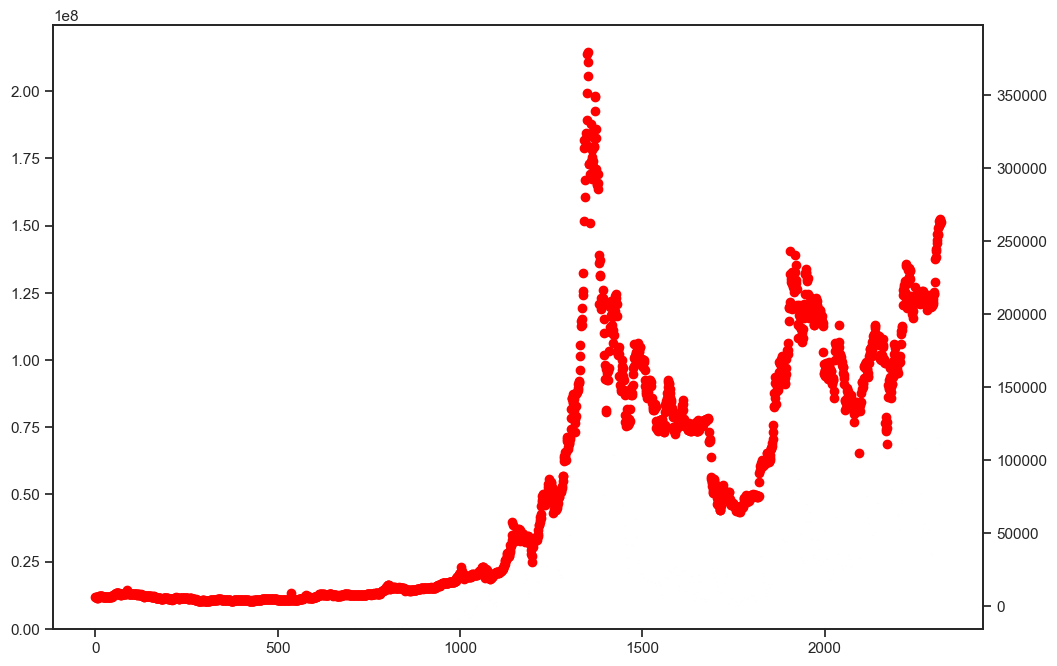

<Figure size 1200x800 with 0 Axes>

In [292]:
y1=crypto.cumulativeWeight[:]
y2=(crypto.high[:]+crypto.low[:])/2
x=range(len(y1))

fig, ax1 = plt.subplots()


ax2=ax1.twinx()
ax1.bar(x,y1)
ax2.plot(x,y2,'o',color='red')

plt.figure(num=None,figsize=(12,8),dpi=100)

plt.show()


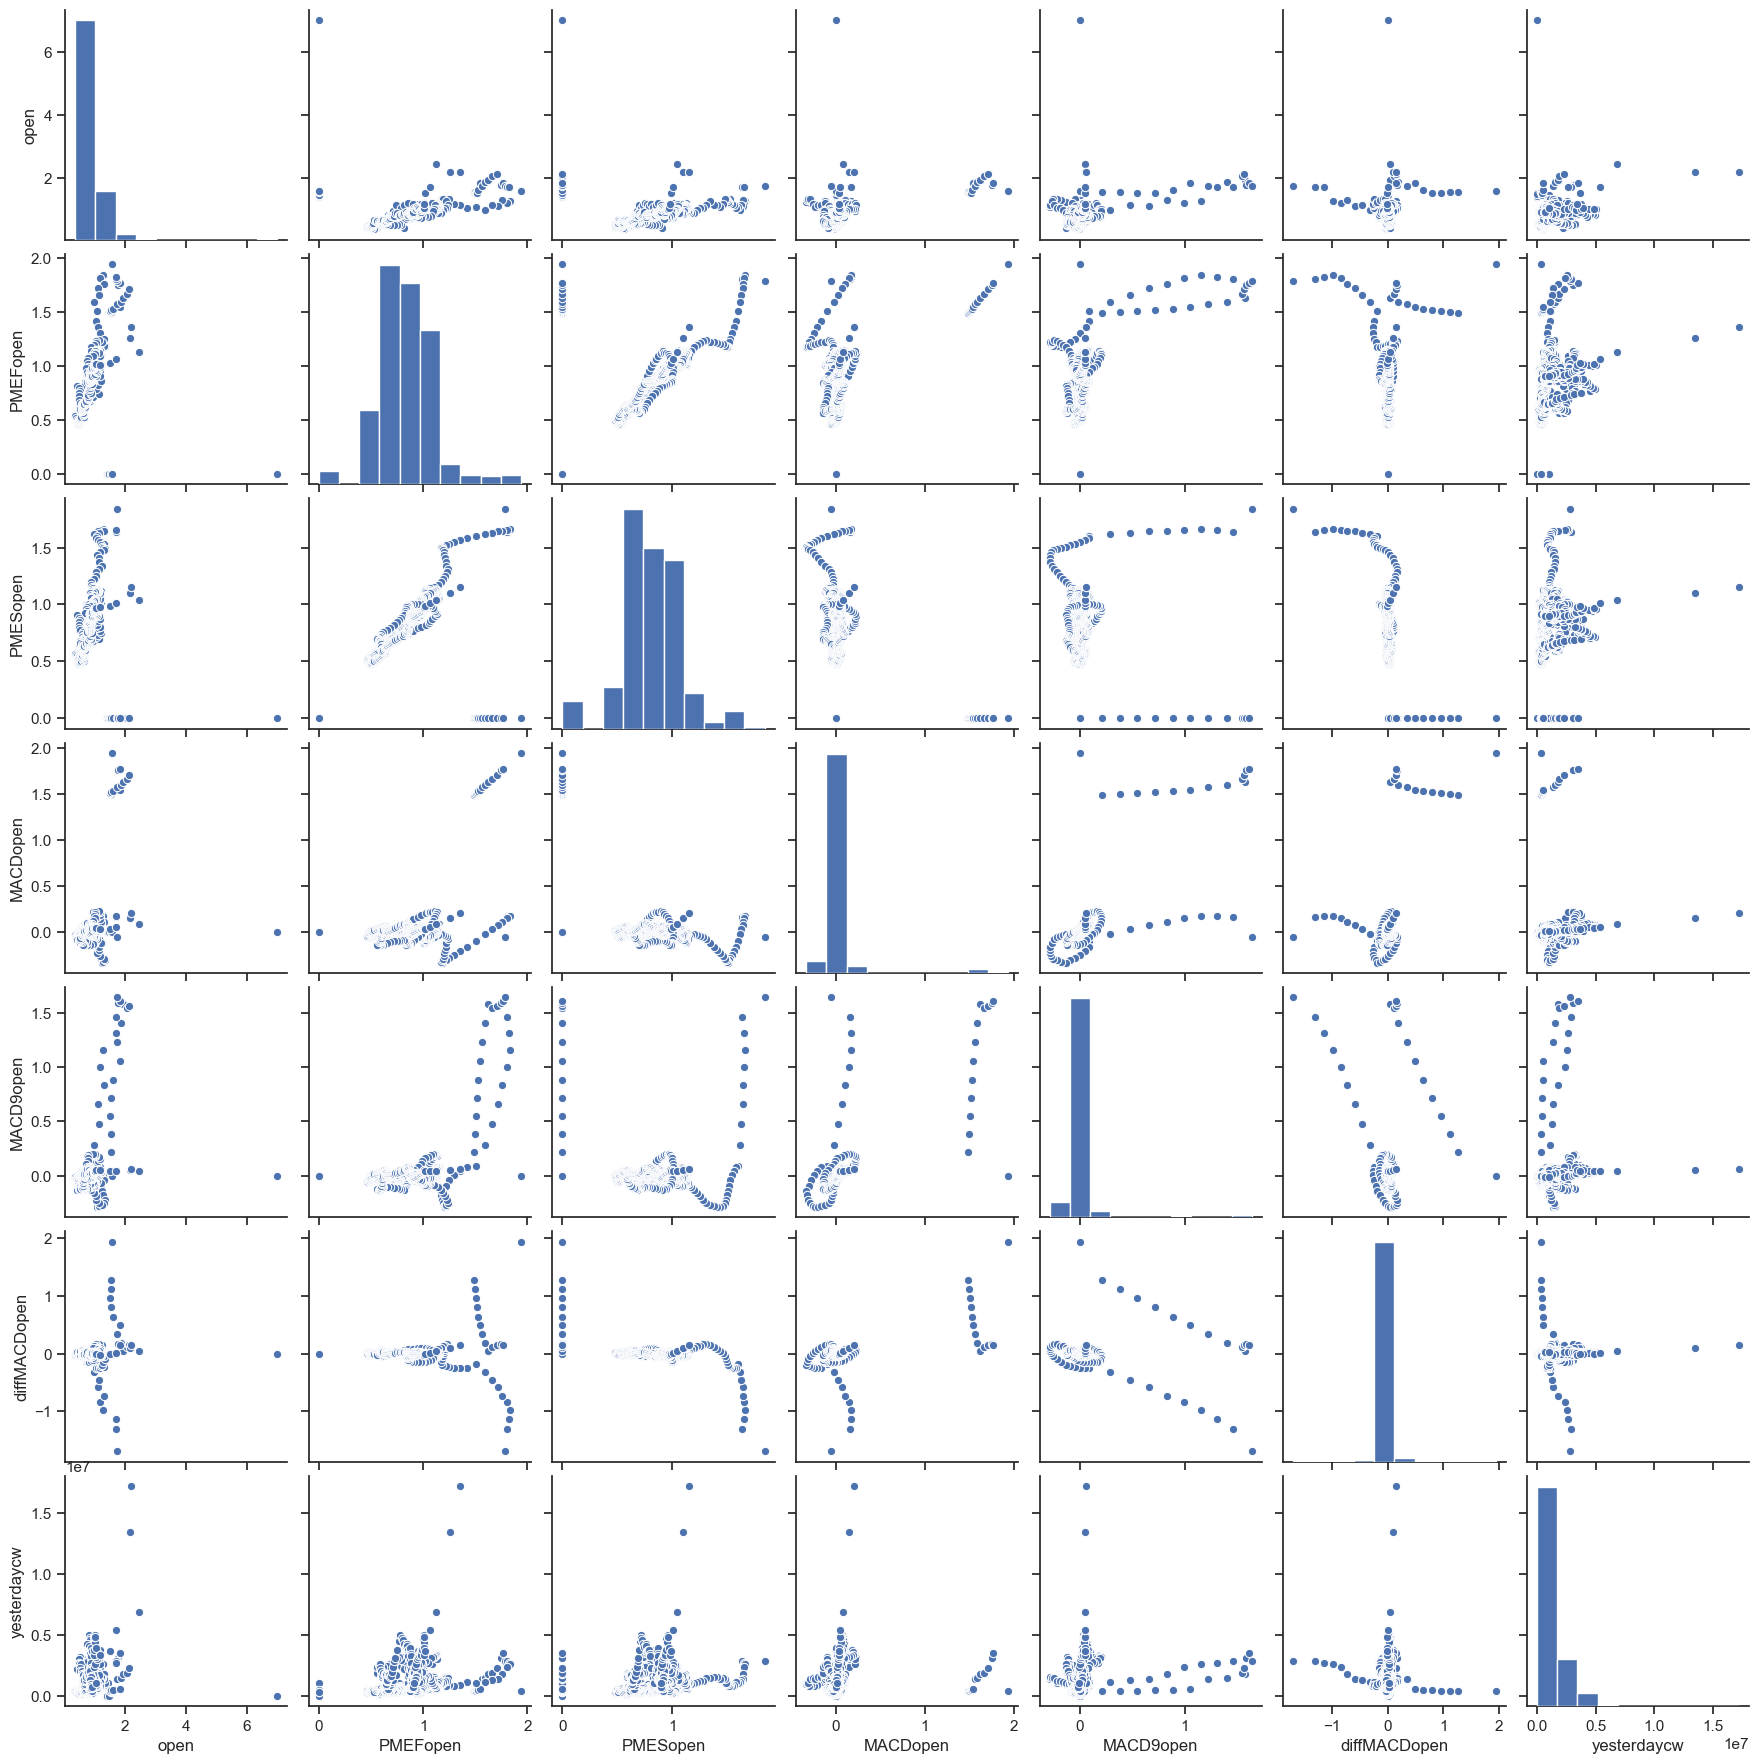

In [206]:
sns.set(style="ticks")
sns.pairplot(crypto[['open','PMEFopen','PMESopen', 'MACDopen', 'MACD9open', 'diffMACDopen','yesterdaycw']])

In [208]:
crypto[['open','PMEFopen','PMESopen', 'MACDopen', 'MACD9open', 'diffMACDopen','yesterdaycw']].corr()

,open,PMEFopen,PMESopen,MACDopen,MACD9open,diffMACDopen,yesterdaycw
open,1.000000,0.425758,0.092314,0.374492,0.396219,0.033479,0.296408
PMEFopen,0.425758,1.000000,0.612881,0.426150,0.523824,-0.055367,0.335282
PMESopen,0.092314,0.612881,1.000000,-0.453654,-0.127847,-0.491699,0.242586
MACDopen,0.374492,0.426150,-0.453654,1.000000,0.737150,0.500491,0.100408
MACD9open,0.396219,0.523824,-0.127847,0.737150,1.000000,-0.216071,0.156823
diffMACDopen,0.033479,-0.055367,-0.491699,0.500491,-0.216071,1.000000,-0.055838
yesterdaycw,0.296408,0.335282,0.242586,0.100408,0.156823,-0.055838,1.000000


In [293]:
crr=crypto.corr()
listpred=[]
for i,col in enumerate(crr.columns):
    crr[col]=crr[col].apply(lambda x: abs(x))#All to positive
    crr[col]=crr[col].apply(lambda x: None if x==1 else x) #Drop it self
    cut=crr[col].quantile(.75)
    crr[col]=crr[col].apply(lambda x: x if x>cut else 0) #Drop it self
    
    
    for row in crr.columns:
        listpred.append([])
        if crr[col][row] !=0:
            listpred[i].append(row)
            
crr

,open,low,high,close,volume,PMEFopen,PMESopen,MACDopen,MACD9open,diffMACDopen,...,yesterday_low_12,yesterday_volume_12,yesterday_close_13,yesterday_open_13,yesterday_high_13,yesterday_low_13,yesterday_volume_13,weight,cumulativeWeight,yesterdaycw
open,0.0,0.997339,0.998630,0.997551,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.998252,0.000000,0.999980,0.997614,0.998722,0.998252,0.000000,0.721324,0.834395,0.000000
low,0.0,0.000000,0.000000,0.998236,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
high,0.0,0.000000,0.000000,0.998689,0.376704,0.0,0.0,0.205657,0.213114,0.000000,...,0.000000,0.373055,0.998607,0.000000,0.000000,0.000000,0.373055,0.739767,0.844036,0.864787
close,0.0,0.998236,0.998689,0.000000,0.000000,0.0,0.0,0.204000,0.000000,0.000000,...,0.000000,0.364988,0.000000,0.000000,0.000000,0.000000,0.364988,0.000000,0.835651,0.000000
volume,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.057319,...,0.000000,0.720130,0.000000,0.000000,0.000000,0.000000,0.720130,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yesterday_low_13,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
yesterday_volume_13,0.0,0.000000,0.000000,0.000000,0.720130,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
weight,0.0,0.000000,0.000000,0.000000,0.696875,0.0,0.0,0.330129,0.301636,0.081970,...,0.000000,0.518258,0.000000,0.000000,0.000000,0.000000,0.518258,0.000000,0.000000,0.000000
cumulativeWeight,0.0,0.000000,0.000000,0.000000,0.485437,0.0,0.0,0.362969,0.376295,0.000000,...,0.000000,0.525432,0.000000,0.000000,0.000000,0.000000,0.525432,0.808860,0.000000,0.964084


In [294]:
listpred

[['yesterday_close_0',
  'yesterday_close_1',
  'yesterday_close_2',
  'yesterday_close_3',
  'yesterday_close_4',
  'yesterday_close_5',
  'yesterday_close_6',
  'yesterday_close_7',
  'yesterday_close_8',
  'yesterday_close_9',
  'yesterday_close_10',
  'yesterday_close_11',
  'yesterday_close_12',
  'yesterday_close_13'],
 ['open',
  'close',
  'yesterday_close_0',
  'yesterday_close_1',
  'yesterday_close_2',
  'yesterday_close_3',
  'yesterday_close_4',
  'yesterday_close_5',
  'yesterday_close_6',
  'yesterday_close_7',
  'yesterday_close_8',
  'yesterday_close_9',
  'yesterday_close_10',
  'yesterday_close_11',
  'yesterday_close_12',
  'yesterday_close_13'],
 ['open',
  'close',
  'yesterday_close_0',
  'yesterday_close_1',
  'yesterday_close_2',
  'yesterday_close_3',
  'yesterday_close_4',
  'yesterday_close_5',
  'yesterday_close_6',
  'yesterday_close_7',
  'yesterday_close_8',
  'yesterday_close_9',
  'yesterday_close_10',
  'yesterday_close_11',
  'yesterday_close_12',
  

## Ideas

- Considerar acumulado de los volumenes para los pronósticos
- Considerar un criterio para la clasificacion de dias de compra, venta y compraventa
- Considadr pronosticos de más de un dia quizás de una semana para determinar puntos de compra venta dentro de la semana
- Reducir variables poco significativas
- Realizar visualizaciones para detectar correlaciones y variables poco significativas
- Hace clasificación no supervisada de 2 a 5 clusters

# New algorithm

This algorithm looks for the most representative correlation using just the quantil 75 of them to find the prediction

## Load and Transform

In [387]:
#Global Variables
coins=['btc','eth','xrp','ltc','bch','tusd','mana','gnt','bat','dai']

#Opening All databases
data=[]
for i,e in enumerate(coins):
    file=e+'-mxn.csv'
    data.append(pd.read_csv(file))
#Conversion of dates from strin to timestamps
for i in range(len(coins)):
    data[i].date=data[i].date.apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

# Conversion to numeric 
for i in range(len(coins)):
    data[i].open=data[i].open.apply(lambda x: strnum(x))
    data[i].close=data[i].close.apply(lambda x: strnum(x))
    data[i].low=data[i].low.apply(lambda x: strnum(x))
    data[i].high=data[i].high.apply(lambda x: strnum(x))
    data[i].volume=data[i].volume.apply(lambda x: strnum(x))

    yv=yesterday(data,i,14) #Adding past values into the rows

crr=[] #Correlation matrixs
listpred=[] #list of variables to consider for the prediction

for i in range(len(coins)):
    crr.append([])
    listpred.append([])

    crr[i]=data[i].corr()

    for j,col in enumerate(crr[i].columns):
        crr[i][col]=crr[i][col].apply(lambda x: abs(x))#All to positive
        crr[i][col]=crr[i][col].apply(lambda x: None if x==1 else x) #Drop it self
        cut=crr[i][col].quantile(.75)
        crr[i][col]=crr[i][col].apply(lambda x: x if x>cut else 0) #Drop all below quantil 75

        for row in crr[i].columns:
            listpred[i].append([])
            if crr[i][col][row] !=0 and row not in ['open','low','high','close','volume']:
                listpred[i][j].append(row)

## New Predictor Function

In [388]:
def predictor2(data=data,end=0):
    #Create Dataframe for predictions
    preds= pd.DataFrame(columns=metricas)
    preds['coin'] =""
    cols=preds.columns.tolist()
    cols=cols[-1:]+cols[:-1]
    preds=preds[cols]
    preds

    for x in tqdm(range(len(coins))):
        test=data[x][14:len(data[x])-1-end] #Last historical data in this case 14 
        dc=['date','open','close','low','high','volume']

        #Adding new row for predictions
        preds=preds.append([0], ignore_index=True).drop(0,axis=1)
        preds=preds[cols]
        preds['coin'][x]=coins[x]

        for mi,m in enumerate(metricas):
            #Predictions
            X_train, X_test, y_train, y_test=tts(test[listpred[x][mi]],test[m], shuffle=True,random_state=100,test_size=.1)
            modelo=XGBR()
            modelo.fit(X_train, y_train)
            preds[m][x]=modelo.predict(data[x][len(data[x])-1-end:len(data[x])-end][listpred[x][mi]])[0]
            #train_score=modelo.score(X_train, y_train)
            #test_score=modelo.score(X_test, y_test)
            #print ('Score for:', coins[x],m,train_score, test_score)

    #Getting oppenings to make initial corrections

    preds['ropen']=0.0
    for i,e in enumerate(coins):
        preds.ropen[i]=data[i]['open'][len(data[i])-1-end]

    preds['corr']=preds.ropen - preds.open
    preds['pcorr']= (1 - preds.open/preds.ropen)*100
    preds['pcorr']= preds['pcorr'].apply(lambda x: str(x.round(1))+'%')


    #Calculation of investment factors

    preds['go']= preds.close - preds.open
    preds['go']= preds['go'].apply(lambda x: 1 if x>0 else 0)
    preds['buy']=preds.open - (preds.open-preds.low)/3 # 1/3 below the opening regarding the lowest point
    preds['sell']=(preds.high-preds.close)/3+preds.close # 1/3 above the closure regarding the highes point
    preds['rate']=(preds.sell/preds.buy-1)*100
    preds.go=preds.go*preds.rate
    preds.go=preds['go'].apply(lambda x: 1 if x>0 else 0)
    preds.rate=preds.rate.apply(lambda x: x.round(1))

    #Calculuation correction

    preds['buya'] = preds['buy'] + preds['corr']
    preds['sella'] = preds['sell'] # + preds['corr']
    preds['rrate']= (preds['sella']/preds['buya'] - 1)*100
    preds['stoploss'] = preds['low'] + preds['corr']
    preds.rrate=preds.rrate.apply(lambda x: x.round(1))
    preds['go']=preds['rrate']
    preds['go']= preds['go'].apply(lambda x: 1 if x>2 else 0)
    
    return preds

In [389]:
preds=predictor2()

In [390]:
sortedcols=['coin','buya','sella','stoploss','go','rrate']
preds[sortedcols]

,coin,buya,sella,stoploss,go,rrate
0,btc,254587,262673,254887,1,3.2
1,eth,8310.81,8591.21,8117.75,1,3.4
2,xrp,6.18627,6.28291,6.0988,0,1.6
3,ltc,1174.68,1193.04,1126.15,0,1.6
4,bch,6216.5,6254.67,6141.18,0,0.6
5,tusd,22.3796,22.4581,22.1989,0,0.4
6,mana,1.98327,1.95239,1.9498,0,-1.6
7,gnt,1.49243,1.61521,1.33728,1,8.2
8,bat,5.77046,5.88009,5.73138,0,1.9
9,dai,22.81,22.8644,22.7501,0,0.2


In [391]:
preds

,coin,open,close,high,low,volume,ropen,corr,pcorr,go,buy,sell,rate,buya,sella,rrate,stoploss
0,btc,253924,261080,265859,254375,303.71,254436.53,512.655,0.2%,1,254074,262673,3.4,254587,262673,3.2,254887
1,eth,8382.85,8501.3,8771.04,8093.26,2570.54,8407.34,24.4904,0.3%,1,8286.32,8591.21,3.7,8310.81,8591.21,3.4,8117.75
2,xrp,6.20539,6.23107,6.38657,6.07419,3.9983e+06,6.23,0.0246081,0.4%,0,6.16166,6.28291,2.0,6.18627,6.28291,1.6,6.0988
3,ltc,1200.86,1170.36,1238.4,1128.07,2700.89,1198.95,-1.91426,-0.2%,0,1176.6,1193.04,1.4,1174.68,1193.04,1.6,1126.15
4,bch,6189.16,6182.69,6398.63,6076.18,235.358,6254.16,65.0033,1.0%,0,6151.5,6254.67,1.7,6216.5,6254.67,0.6,6141.18
5,tusd,22.577,22.3452,22.6838,22.3059,66182.8,22.47,-0.106996,-0.5%,0,22.4866,22.4581,-0.1,22.3796,22.4581,0.4,22.1989
6,mana,1.88184,1.93252,1.99213,1.83164,4.77623e+06,2.00,0.118161,5.9%,0,1.86511,1.95239,4.7,1.98327,1.95239,-1.6,1.9498
7,gnt,1.65608,1.55693,1.73179,1.42337,1.01426e+06,1.57,-0.0860832,-5.5%,1,1.57851,1.61521,2.3,1.49243,1.61521,8.2,1.33728
8,bat,5.7507,5.85525,5.92976,5.69208,185415,5.79,0.0392976,0.7%,0,5.73116,5.88009,2.6,5.77046,5.88009,1.9,5.73138
9,dai,22.7462,22.7995,22.9943,22.6562,15436.4,22.84,0.0938471,0.4%,0,22.7162,22.8644,0.7,22.81,22.8644,0.2,22.7501
